In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression,SGDClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
#load the dataset
train=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
movie=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")
test=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

In [3]:
#common features identification
cf='movieid'

In [4]:
#merging the datasets
merged_data=pd.merge(train,movie,on=cf,how="left")

In [5]:
movie.drop_duplicates("movieid",keep='first',inplace=True)


In [6]:
merged_data.info()
merged_data.shape


<class 'pandas.core.frame.DataFrame'>
Int64Index: 525277 entries, 0 to 525276
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               525277 non-null  object 
 1   reviewerName          525277 non-null  object 
 2   isFrequentReviewer    525277 non-null  bool   
 3   reviewText            501460 non-null  object 
 4   sentiment             525277 non-null  object 
 5   title                 525277 non-null  object 
 6   audienceScore         224448 non-null  float64
 7   rating                134486 non-null  object 
 8   ratingContents        134486 non-null  object 
 9   releaseDateTheaters   182326 non-null  object 
 10  releaseDateStreaming  249433 non-null  object 
 11  runtimeMinutes        302589 non-null  float64
 12  genre                 307944 non-null  object 
 13  originalLanguage      304822 non-null  object 
 14  director              525277 non-null  object 
 15  

(525277, 18)

In [7]:
#Checking the null values
merged_data.isnull().sum()

movieid                      0
reviewerName                 0
isFrequentReviewer           0
reviewText               23817
sentiment                    0
title                        0
audienceScore           300829
rating                  390791
ratingContents          390791
releaseDateTheaters     342951
releaseDateStreaming    275844
runtimeMinutes          222688
genre                   217333
originalLanguage        220455
director                     0
boxOffice               380216
distributor             355592
soundType               415919
dtype: int64

In [8]:

merged_data['reviewText']=merged_data['reviewText'].fillna(value=' ')



In [9]:
#from sklearn.impute import SimpleImputer

#imputer=SimpleImputer(strategy="most_frequent")


In [10]:
#imputer=imputer.fit(merged_data[['reviewText']])


In [11]:
#merged_data[['reviewText']]=imputer.transform(merged_data[['reviewText']])

In [12]:
#from sklearn.impute import SimpleImputer
#imputer=SimpleImputer(strategy="mean")
#merged_data[['audienceScore','runtimeMinutes']]=imputer.fit_transform(merged_data[['audienceScore','runtimeMinutes']])

In [13]:
merged_data.head(5)

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,Marvelous Pirate,65.0,PG-13,"['Violence', 'Brief Strong Language', 'Substan...",2022-10-21,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,NaN,Netflix,NaN
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,Tony Montana Frodo Baggins V Rocky Balboa,NaN,NaN,NaN,NaN,2013-01-08,91.0,Action,English,Alma White,NaN,NaN,NaN
2,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,Tony Montana Frodo Baggins V Rocky Balboa,47.0,PG-13,"['Some Sexual Material', 'Brief Partial Nudity']",2010-02-12,2010-05-18,119.0,"Holiday, Romance, Comedy, Lgbtq+",English,Hubert Dixon,$110.5M,Warner Bros.,"Dolby Digital, DTS"
3,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE,Darth Vader Katniss Everdeen Sorcerer Donnie D...,80.0,PG-13,"['Language', 'A Scene of Sensuality', 'Sports ...",2018-11-21,2019-02-12,130.0,Drama,English,Bobby Oleary,$115.7M,"Warner Bros. Pictures, Metro-Goldwyn-Mayer",NaN
4,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE,Lara Croft Glimmer,NaN,NaN,NaN,NaN,2020-06-02,15.0,Drama,Spanish,Eric Hutcherson,NaN,NaN,NaN


****EDA-Exploratory Data Analysis****

In [14]:
merged_data['sentiment'].value_counts()


POSITIVE    350583
NEGATIVE    174694
Name: sentiment, dtype: int64

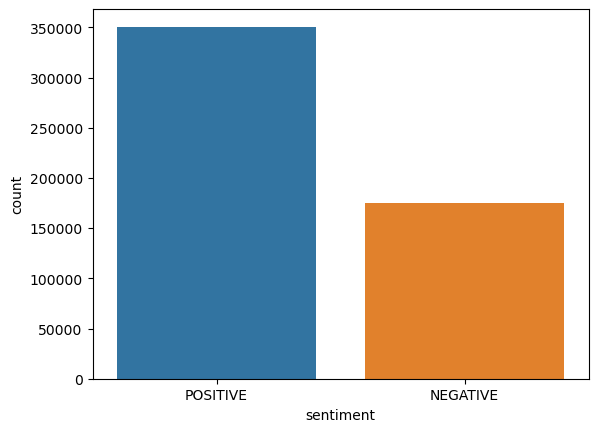

In [15]:
sns.countplot(x='sentiment', data=merged_data)  
plt.show()


In [16]:
merged_data['audienceScore'].value_counts()


80.0    4724
86.0    4721
83.0    4636
77.0    4599
89.0    4541
        ... 
8.0       97
6.0       61
4.0       26
2.0        2
3.0        1
Name: audienceScore, Length: 100, dtype: int64

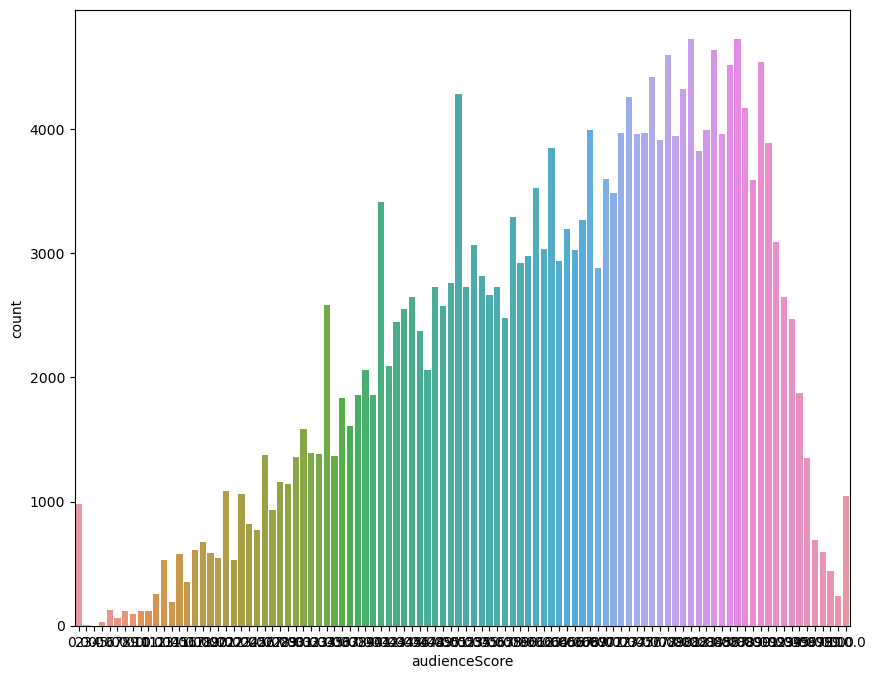

In [17]:
plt.figure(figsize=(10,8))
sns.countplot(x='audienceScore', data=merged_data)  
plt.show()


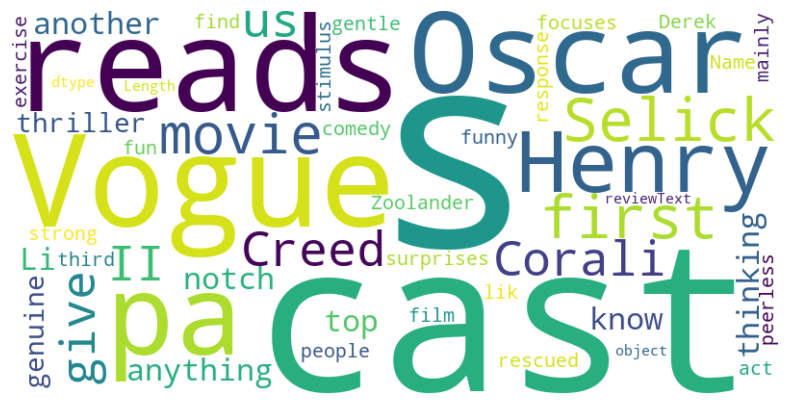

In [18]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str(merged_data['reviewText']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis ticks and labels
plt.show()


In [19]:
# #Preprocessing the textual feature
def clean_text(reviewText):
    reviewText=str(reviewText).lower()  #convert to lowercase
    reviewText=re.sub('\[.*?\]','',reviewText)
    reviewText=re.sub('https?://\S+|www\.\S+','',reviewText)#Remove URLs
    reviewText=re.sub('<.*?>+','',reviewText)
    reviewText=re.sub(r'[^a-z0-9\s]','',reviewText)   #Remove punctuation
    reviewText=re.sub('\n','',reviewText)
    reviewText=re.sub('\w*\d\w*','',reviewText)
    return reviewText


In [20]:
merged_data['reviewText']=merged_data['reviewText'].apply(clean_text)
merged_data

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,marvelous_pirate,Benjamin Henry,False,henry selicks first movie since coraline his ...,POSITIVE,Marvelous Pirate,65.0,PG-13,"['Violence', 'Brief Strong Language', 'Substan...",2022-10-21,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,NaN,Netflix,NaN
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,with a cast that reads like the vogue oscar pa...,NEGATIVE,Tony Montana Frodo Baggins V Rocky Balboa,NaN,NaN,NaN,NaN,2013-01-08,91.0,Action,English,Alma White,NaN,NaN,NaN
2,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,with a cast that reads like the vogue oscar pa...,NEGATIVE,Tony Montana Frodo Baggins V Rocky Balboa,47.0,PG-13,"['Some Sexual Material', 'Brief Partial Nudity']",2010-02-12,2010-05-18,119.0,"Holiday, Romance, Comedy, Lgbtq+",English,Hubert Dixon,$110.5M,Warner Bros.,"Dolby Digital, DTS"
3,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,creed ii does not give us anything but another...,POSITIVE,Darth Vader Katniss Everdeen Sorcerer Donnie D...,80.0,PG-13,"['Language', 'A Scene of Sensuality', 'Sports ...",2018-11-21,2019-02-12,130.0,Drama,English,Bobby Oleary,$115.7M,"Warner Bros. Pictures, Metro-Goldwyn-Mayer",NaN
4,lara_croft_glimmer,Ryan Barrett,False,i know what youre thinking but this is no limi...,POSITIVE,Lara Croft Glimmer,NaN,NaN,NaN,NaN,2020-06-02,15.0,Drama,Spanish,Eric Hutcherson,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525272,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,a topnotch thriller with genuine surprises and...,POSITIVE,The Joker Ethereal Captain Jack Sparrow Fantastic,NaN,NaN,NaN,1943-05-15,NaN,104.0,Drama,Russian,Keith Flores,NaN,Artkino Pictures Inc.,Mono
525273,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,some people find derek zoolander funny and lik...,NEGATIVE,E.T. Hannibal Lecter Vito Corleone Katniss Eve...,20.0,PG-13,"['Crude and Sexual Content', 'Brief Strong Lan...",2016-02-12,2016-05-24,102.0,"Comedy, Adventure",English,Susan Oley,$28.8M,Paramount Pictures,NaN
525274,infinite_enigma_luke_skywalker,Bryan Wilson,False,this fun gentle comedy focuses mainly on theme...,POSITIVE,Infinite Enigma Luke Skywalker,78.0,PG-13,"['Some Language', 'Suggestive References']",NaN,2022-06-17,90.0,"Comedy, Drama",English,Bryant Reams,NaN,NaN,Dolby Digital
525275,emerald_oracle_iron_man_wolverine,Erik Parker,False,the film is rescued by a strong third act but ...,NEGATIVE,Emerald Oracle Iron Man Wolverine,39.0,NaN,NaN,1996-11-16,1998-11-03,88.0,"Kids & family, Holiday, Comedy",English,Lisa Cruz,$60.6M,20th Century Fox,Surround


In [21]:
x=merged_data['reviewText']
x

0         henry selicks first movie since  coraline his ...
1         with a cast that reads like the vogue oscar pa...
2         with a cast that reads like the vogue oscar pa...
3         creed ii does not give us anything but another...
4         i know what youre thinking but this is no limi...
                                ...                        
525272    a topnotch thriller with genuine surprises and...
525273    some people find derek zoolander funny and lik...
525274    this fun gentle comedy focuses mainly on theme...
525275    the film is rescued by a strong third act but ...
525276             a peerless exercise in stimulus response
Name: reviewText, Length: 525277, dtype: object

In [22]:
#x=merged_data[['reviewText','audienceScore','runtimeMinutes']]
#x

In [23]:
x.isnull().sum()

0

In [24]:
y=merged_data['sentiment']
y

0         POSITIVE
1         NEGATIVE
2         NEGATIVE
3         POSITIVE
4         POSITIVE
            ...   
525272    POSITIVE
525273    NEGATIVE
525274    POSITIVE
525275    NEGATIVE
525276    POSITIVE
Name: sentiment, Length: 525277, dtype: object

In [25]:
#Applying label encoding 
label_encoder=LabelEncoder()
y_encoded=label_encoder.fit_transform(y)


In [26]:
y_encoded

array([1, 0, 0, ..., 1, 0, 1])

In [27]:
#TF-IDF Vectorizer
#tfidf_v = TfidfVectorizer(max_features=100)
#x_tfidf_v= tfidf_v.fit_transform(x['reviewText'].values)


In [28]:
#x_array=x_tfidf_vec.toarray()


In [29]:
#x_new= pd.DataFrame(x_array)
#x_new.head()

In [30]:
#x_new.columns = x_new.columns.astype(str)
#x_new.columns.map(type)

In [31]:
#x_final=pd.concat([x,x_new],axis=1)
#x_final.head()

In [32]:
#x_final.drop(['reviewText'],axis=1,inplace=True)

In [33]:
#x_final.head()

In [34]:
#x_final['runtimeMinutes']=x_final['runtimeMinutes'].astype(int)

In [35]:
#x_final['audienceScore']=x_final['audienceScore'].astype(int)

In [36]:
#cv=CountVectorizer(stop_words='english')
#cv=cv.fit(x)
#x_cv=cv.transform(x)


In [37]:
#Splitting  dataset into train and test
x_train,x_val,y_train,y_val = train_test_split(x,y_encoded,test_size=0.2,random_state=40)



In [38]:
tfidf_v = TfidfVectorizer()
x_tfidf_v= tfidf_v.fit_transform(x_train)

In [39]:
x_tfidf_val= tfidf_v.transform(x_val)

In [40]:
#from imblearn.under_sampling import RandomUnderSampler
#us = RandomUnderSampler()
#x_resample, y_resample = us.fit_resample(x_tfidf_v, y_train)

In [41]:
from scipy.stats import uniform

lr = LogisticRegression()

# Define hyperparameters and their possible values
param_dist = {
    'C': uniform(0.1, 10), 
    'solver': ['liblinear', 'saga'],
    'penalty':['l1','l2']
}

In [42]:
pipe=Pipeline([('randomize_search', RandomizedSearchCV(lr,param_distributions=param_dist,n_iter=10,cv=5,random_state=42,n_jobs=-1))])

In [43]:
pipe.fit(x_tfidf_v,y_train)

Pipeline(steps=[('randomize_search',
                 RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                                    n_jobs=-1,
                                    param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79355a3544f0>,
                                                         'penalty': ['l1',
                                                                     'l2'],
                                                         'solver': ['liblinear',
                                                                    'saga']},
                                    random_state=42))])

In [44]:
y_pred1=pipe.predict(x_tfidf_val)


In [45]:
from sklearn.metrics import f1_score
f1_score(y_val, y_pred1, average='micro')

0.9186624276576302

In [46]:
#Logistic

#model=LogisticRegression(max_iter=1000)
#model.fit(x_train,y_train)

In [47]:
#from sklearn.metrics import f1_score
#y_pred=model.predict(x_val)


In [48]:
#f1_score(y_val, y_pred, average='micro')


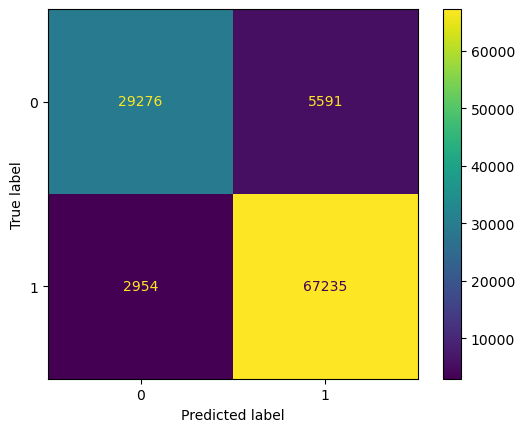

In [49]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm=confusion_matrix(y_val,y_pred1)
cm_dis=ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=pipe.classes_)
cm_dis.plot()
plt.show()



In [50]:
from sklearn.metrics import classification_report

In [51]:
print(classification_report(y_val,y_pred1))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87     34867
           1       0.92      0.96      0.94     70189

    accuracy                           0.92    105056
   macro avg       0.92      0.90      0.91    105056
weighted avg       0.92      0.92      0.92    105056



In [52]:
#LinearSVC

from sklearn.svm import LinearSVC
linear_svc=LinearSVC()


In [53]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [1000, 5000]
}

In [54]:
gs = GridSearchCV(linear_svc, param_grid, cv=5, scoring='accuracy')
gs.fit(x_tfidf_v, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'loss': ['hinge', 'squared_hinge'],
                         'max_iter': [1000, 5000]},
             scoring='accuracy')

In [55]:
best_params = gs.best_params_
svc = gs.best_estimator_

In [56]:
from sklearn.metrics import f1_score
y_pred = svc.predict(x_tfidf_val)


In [57]:
f1_score(y_val, y_pred, average='micro')


  

0.9168633871459031

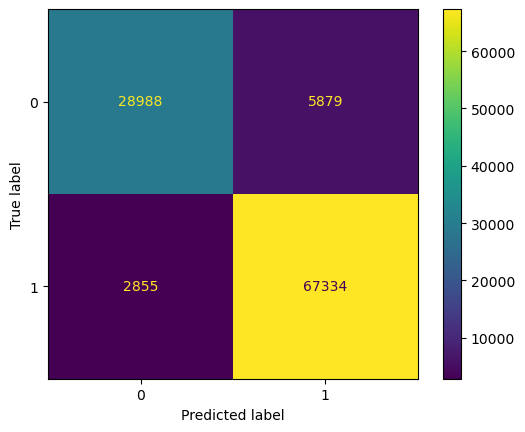

In [58]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm=confusion_matrix(y_val,y_pred)
cm_dis=ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=svc.classes_)
cm_dis.plot()
plt.show()

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87     34867
           1       0.92      0.96      0.94     70189

    accuracy                           0.92    105056
   macro avg       0.92      0.90      0.90    105056
weighted avg       0.92      0.92      0.92    105056



In [60]:
#MultinomialNB

from sklearn.naive_bayes import MultinomialNB
model_2=MultinomialNB()
model_2.fit(x_tfidf_v,y_train)

MultinomialNB()

In [61]:
param_grid_2={'alpha':[0.1,0.5,1.0]}

In [62]:
grid_search_2=GridSearchCV(model_2,param_grid_2,cv=5)
grid_search_2.fit(x_tfidf_v,y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0]})

In [63]:
best_params=grid_search_2.best_params_
best_score=grid_search_2.best_score_
best_params

{'alpha': 0.1}

In [64]:
model_nb=grid_search_2.best_estimator_


In [65]:
# Evaluate the best model on your test data
from sklearn.metrics import f1_score
y_pred=model_nb.predict(x_tfidf_val)



In [66]:
f1_score(y_val, y_pred, average='micro')

0.8908201340237587

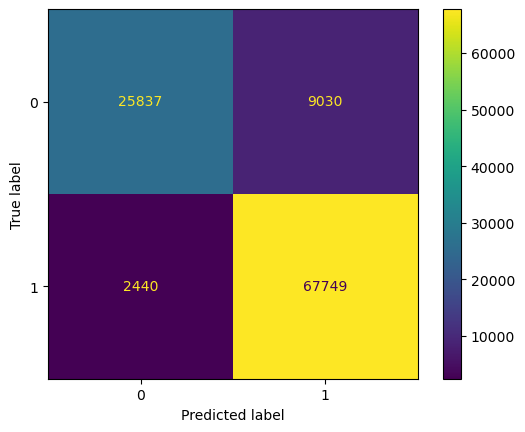

In [67]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm=confusion_matrix(y_val,y_pred)
cm_dis=ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=model_nb.classes_)
cm_dis.plot()
plt.show()



In [68]:
from sklearn.metrics import classification_report

In [69]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82     34867
           1       0.88      0.97      0.92     70189

    accuracy                           0.89    105056
   macro avg       0.90      0.85      0.87    105056
weighted avg       0.89      0.89      0.89    105056



In [70]:
#KNN

#from sklearn.neighbors import KNeighborsClassifier

In [71]:
#param_grid_3={'n_neighbors':[3,5,7,9,11]}

In [72]:
#knn=KNeighborsClassifier()
#grid_search_3=GridSearchCV(knn,param_grid_3,cv=5)

In [73]:
#grid_search_3.fit(x_train,y_train)

In [74]:
#best_params=grid_search_3.best_params_
#best_score=grid_search_3.best_score_
#best_params

In [75]:
#model_knn=grid_search_3.best_estimator_
#accuracy=model_knn.score(x_val,y_val)
#accuracy

In [76]:
#Validation Accuracy
#model_knn.score(x_val,y_val)

In [77]:
#xgboost 

#import xgboost as xgb


In [78]:
#xgb = xgb.XGBClassifier(
    #objective="binary:logistic",  # For binary classification
    #learning_rate=0.1,
    #max_depth=3,
    #n_estimators=100
#)

In [79]:
#xgb.fit(x_train, y_train)


In [80]:
#y_pred=xgb.predict(x_val)


In [81]:
#f1_score(y_val, y_pred, average='micro')

In [82]:
#SGD

In [83]:
#sgd = SGDClassifier(loss='log_loss', alpha=0.01, max_iter=1000, random_state=42)


In [84]:
#sgd.fit(x_train, y_train)

In [85]:
#y_pred=sgd.predict(x_val)


In [86]:
#f1_score(y_val, y_pred, average='macro')

In [87]:
#DecisionTree

In [88]:
#from sklearn.tree import DecisionTreeClassifier
#model5 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=40)
#model5.fit(x_train,y_train)

In [89]:
#from sklearn.metrics import f1_score
#y_pred=model5.predict(x_val)
#y_pred

In [90]:
#f1_score(y_val, y_pred, average='macro')



In [91]:
#SVM

In [92]:
#from sklearn.svm import SVC
#svm=SVC()
#svm.fit(x_train, y_train)


In [93]:
#from sklearn.metrics import f1_score
#y_pred=svm.predict(x_val)


In [94]:
#f1_score(y_val, y_pred, average='macro')



In [95]:
#Load the test dataset
test_dataset=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
test_dataset.info()
test_dataset.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


(55315, 4)

In [96]:
cf_test='movieid'

In [97]:
movie.drop_duplicates("movieid",keep='first',inplace=True)


In [101]:
merged_data_test=pd.merge(test,movie,on=cf,how="left")

In [102]:
merged_data_test.shape

(55315, 17)

In [103]:
#merged_data_test[['reviewText']]=imputer.transform(merged_data_test[['reviewText']])



In [104]:
#Filling the values in reviewText column
#x_test=test_dataset['reviewText'].fillna(value=' ')


In [105]:
x_test=merged_data_test['reviewText'].fillna(value=' ')


In [106]:
# Preprocessing the test dataset
def clean_text(reviewText):
    reviewText=str(reviewText).lower()  #convert to lowercase
    reviewText=re.sub('\[.*?\]','',reviewText)
    reviewText=re.sub('https?://\S+|www\.\S+','',reviewText)#Remove URLs
    reviewText=re.sub('<.*?>+','',reviewText)
    reviewText=re.sub(r'[^a-z0-9\s]','',reviewText)   #Remove punctuation
    reviewText=re.sub('\n','',reviewText)
    reviewText=re.sub('\w*\d\w*','',reviewText)
    return reviewText

In [107]:
x_test=x_test.apply(clean_text)
x_test

0        green slowly cranks up the dread with style an...
1        philip noyces direction is elegant and unforce...
2        it wouldnt do to say what path maria ultimatel...
3        pig is not exactly the arthouse john wick that...
4        an imaginative nobudget musical of sorts about...
                               ...                        
55310    ron howard delivers an unconventional romantic...
55311    as an oddball art film that openly invites you...
55312    nicholson wears his devilish grin from his fir...
55313    its hard not be entertained by two dozen of co...
55314    not clever enough for smith fans not gross eno...
Name: reviewText, Length: 55315, dtype: object

In [108]:
#Vectorize the test data 
#cv=CountVectorizer(stop_words='english')
#cv=cv.fit(x)
#x_cv=cv.transform(x)
#x_cv=cv.transform(x_test)

In [109]:
#vectorize the data
x_tfidf_v=tfidf_v.transform(x_test)

In [110]:
y_pred1=pipe.predict(x_tfidf_v)

In [111]:
y_pred1

array([1, 1, 1, ..., 0, 1, 0])

In [112]:
y_pred = label_encoder.inverse_transform(y_pred1)


In [113]:
y_pred

array(['POSITIVE', 'POSITIVE', 'POSITIVE', ..., 'NEGATIVE', 'POSITIVE',
       'NEGATIVE'], dtype=object)

In [114]:
#Predict the labels for the test data
#testdata_label_pred=best_model.predict(x_tfidf_v)

In [115]:
# Decode the encoded predictions
#y_pred = label_encoder.inverse_transform(testdata_label_pred)


In [116]:
#y_pred

In [117]:
#testdata_label_pred.shape

In [118]:
y_pred.shape

(55315,)

In [119]:
output_data=pd.DataFrame({'id':range(len(y_pred)),'sentiment': y_pred})
output_data.to_csv('submission.csv',index=False)

In [120]:
output_data

,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,NEGATIVE
55312,55312,NEGATIVE
55313,55313,POSITIVE
